In [1]:
import argparse
import os
import copy
import glob
import numpy as np
import torch
from PIL import Image, ImageDraw, ImageFont
from torchvision.ops import box_convert

# Grounding DINO
import GroundingDINO.groundingdino.datasets.transforms as T
from GroundingDINO.groundingdino.models import build_model
from GroundingDINO.groundingdino.util import box_ops
from GroundingDINO.groundingdino.util.slconfig import SLConfig
from GroundingDINO.groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
from GroundingDINO.groundingdino.util.inference import annotate, load_image, predict

import supervision as sv

# segment anything
from segment_anything import build_sam, SamPredictor 
import cv2
import numpy as np
import matplotlib.pyplot as plt


# diffusers
import PIL
import requests
import torch
from io import BytesIO
from diffusers import StableDiffusionInpaintPipeline


from huggingface_hub import hf_hub_download

c:\Users\tls15\anaconda3\envs\GS\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\tls15\Documents\01.Program\Grounded-Segment-Anything\GroundingDINO\groundingdino\models\GroundingDINO\ms_deform_attn.py:31: UserWarning: Failed to load custom C++ ops. Running on CPU mode Only!
  warnings.warn("Failed to load custom C++ ops. Running on CPU mode Only!")


In [2]:
def load_model_hf(repo_id, filename, ckpt_config_filename, device='cuda'):
	cache_config_file = hf_hub_download(repo_id=repo_id, filename=ckpt_config_filename)

	args = SLConfig.fromfile(cache_config_file) 
	model = build_model(args)
	args.device = device

	cache_file = hf_hub_download(repo_id=repo_id, filename=filename)
	checkpoint = torch.load(cache_file, map_location='cuda')
	log = model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
	print("Model loaded from {} \n => {}".format(cache_file, log))
	_ = model.eval()
	return model 

In [3]:
# Use this command for evaluate the Grounding DINO model
# Or you can download the model by yourself
ckpt_repo_id = "ShilongLiu/GroundingDINO"
ckpt_filenmae = "groundingdino_swinb_cogcoor.pth"
ckpt_config_filename = "GroundingDINO_SwinB.cfg.py"

groundingdino_model = load_model_hf(ckpt_repo_id, ckpt_filenmae, ckpt_config_filename, device='cuda')

final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model loaded from C:\Users\tls15\.cache\huggingface\hub\models--ShilongLiu--GroundingDINO\snapshots\a94c9b567a2a374598f05c584e96798a170c56fb\groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight'])


In [4]:
print(os.getcwd())
sam_checkpoint = "./weights/sam_vit_h_4b8939.pth"
if not os.path.isfile(sam_checkpoint):
    raise Exception
sam = build_sam(checkpoint=sam_checkpoint)
sam.to(device="cuda")
sam_predictor = SamPredictor(sam)

c:\Users\tls15\Documents\01.Program\Grounded-Segment-Anything


In [5]:
import glob

IMAGE_PATHS = sorted(glob.glob(os.path.join("Z:\\05. Data\\02. Training&Test\\021. Korean_Express_Corporation\\## 24.03_신축이음부모니터링\\## IMG\\## joint\\*.jpg")))
for i, path in enumerate(IMAGE_PATHS):
	print(f"{path}\n")
	if i == 3:
		break

Z:\05. Data\02. Training&Test\021. Korean_Express_Corporation\## 24.03_신축이음부모니터링\## IMG\## joint\P-027-S1-하원곡1교(부산)_s000058000.jpg

Z:\05. Data\02. Training&Test\021. Korean_Express_Corporation\## 24.03_신축이음부모니터링\## IMG\## joint\P-039-E2-학하2교(대전)_s000020000.jpg

Z:\05. Data\02. Training&Test\021. Korean_Express_Corporation\## 24.03_신축이음부모니터링\## IMG\## joint\P-039-E2-학하2교(대전)_s000032000.jpg

Z:\05. Data\02. Training&Test\021. Korean_Express_Corporation\## 24.03_신축이음부모니터링\## IMG\## joint\P-039-E2-학하2교(대전)_s000034000.jpg



In [6]:
def split_image(image_path, width=2000):
    # Load the image from the specified path
    img = cv2.imdecode(np.fromfile(image_path, dtype=np.uint8), cv2.IMREAD_UNCHANGED)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # img_height, img_width, d = img.shape
    
    pil_img = Image.fromarray(img)
    img_width, img_height = pil_img.size

    print(img_width, img_height)

    # Calculate the number of full 2000 pixel wide segments
    n_full_segments = img_width // width
    remainder_width = img_width % width

    segments = []

    # Extract each full segment
    for i in range(n_full_segments):
        if i == 8:  # Special handling for the ninth segment
            left = i * width
            right = left + width + remainder_width  # Include the remainder in the ninth segment
            segment = pil_img.crop((left, 0, right, img_height))
            segments.append(segment)
        else:
            left = i * width
            right = left + width
            segment = pil_img.crop((left, 0, right, img_height))
            segments.append(segment)

    return segments

image_path = IMAGE_PATHS[0]
segments = split_image(image_path)
# segments[0].show()

18592 10000


Data Type : <class 'torch.Tensor'>
Data shape : torch.Size([3, 1335, 267])


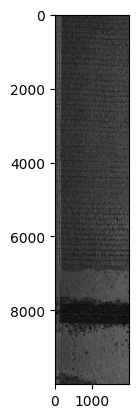

In [7]:
transform = T.Compose(
    [
	T.RandomResize([800], max_size=1333),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225]),
    ]
)

image_source = np.asarray(segments[0])
image, _ = transform(segments[0].convert("RGB"), None)

print(f"Data Type : {type(image)}\nData shape : {image.size()}")
plt.imshow(image_source)
# Assume 'image' is a PyTorch tensor from your example
# Ensure the tensor is on the CPU and detached from the computation graph
# image_np = image.cpu().detach().numpy()

# # PyTorch tensors are in CxHxW format and need to be converted to HxWxC for typical image visualization in tools like Matplotlib
# image_np = np.transpose(image_np, (1, 2, 0))

# # Normalize the image for display if necessary (since it was normalized by the mean and std of the dataset)
# mean = np.array([0.485, 0.456, 0.406])
# std = np.array([0.229, 0.224, 0.225])
# image_np = std * image_np + mean
# image_np = np.clip(image_np, 0, 1)\

# plt.imshow(image_np)

In [8]:
TEXT_PROMPT = "Steel Expansion Joint"
BOX_TRESHOLD = 0.25
TEXT_TRESHOLD = 0.20
DEVICE = "cuda"

boxes, logits, phrases = predict(
	model = groundingdino_model,
	image = image,
	caption = TEXT_PROMPT,
	box_threshold=BOX_TRESHOLD,
	text_threshold=TEXT_TRESHOLD,
	device = DEVICE
)

if logits.nelement() == 0:
    print("Expansion Joint is not detected...!!")
else:
    print("Expansion Joint is Detected..!")

annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
annotated_frame = annotated_frame[...,::-1] # BGR to RGB

plt.figure(figsize=(15,8))
plt.imshow(annotated_frame)

NameError: name '_C' is not defined

In [61]:
 # set image
sam_predictor.set_image(image_source)
# box : normalized box xywh -> unnormalized xyxy
H, W, _ = image_source.shape
boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])

transformed_boxes = sam_predictor.transform.apply_boxes_torch(boxes_xyxy, image_source.shape[:2]).to('cuda:0')
masks, _, _ = sam_predictor.predict_torch(
			point_coords = None,
			point_labels = None,
			boxes = transformed_boxes,
			multimask_output = False,
		)

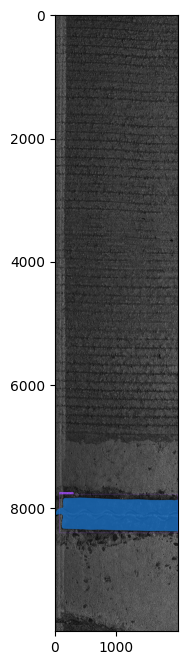

In [62]:
annotated_frame_with_mask = show_mask(masks[0][0], annotated_frame, random_color=False)
plt.figure(figsize=(15,8))
plt.imshow(annotated_frame_with_mask)

In [ ]:
def crop_masked_region(image, mask):
	"""
	Crop the region of the image where the mask is True.

	Parameters:
	- image: The original image as a numpy array.
	- mask: The binary mask where True indicates the object.

	Returns:
	- The cropped image around the masked region.
	"""
	# Ensure the mask is a boolean array
	# mask = mask.astype(bool)
	if mask.device.type == "cuda":
		mask = mask.cpu().numpy()

	# Find the bounding box of the non-zero regions in the mask
	coords = np.argwhere(mask)
	if coords.size == 0:
		return None  # Return None if the mask is completely False/0

	# Extract the min and max coordinates on both axes
	y_min, x_min = coords.min(axis=0)
	y_max, x_max = coords.max(axis=0) + 1  # Add 1 for inclusive slicing

	# Crop the image
	cropped_image = image[y_min:y_max, x_min:x_max]

	return cropped_image

In [16]:
IMAGE_PATHS = sorted(glob.glob(os.path.join("/home/gyumin/Data/EX/*/*/*.png")))
for i, path in enumerate(IMAGE_PATHS):
	print(f"{path}\n")
	if i == 3:
		break

/home/gyumin/Data/EX/1/splitted/segment_1.png

/home/gyumin/Data/EX/1/splitted/segment_2.png

/home/gyumin/Data/EX/1/splitted/segment_3.png

/home/gyumin/Data/EX/1/splitted/segment_4.png



In [30]:
def crop_image(image_path, box_xyxy):
    # Load the image
    img = Image.open(image_path)
    
    # Convert the bounding box to integer coordinates
    # Ensure coordinates are within the image dimensions and are integers
    left, top, right, bottom = box_xyxy.int().tolist()
    
    # Perform cropping
    cropped_image = img.crop((left, top, right, bottom))
    
    return cropped_image

def show_mask(mask, image, random_color=True):
	mask = mask.cpu()
	if random_color:
		color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
	else:
		color = np.array([30/255, 144/255, 255/255, 0.6])
	h, w = mask.shape[-2:]
	mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
	
	annotated_frame_pil = Image.fromarray(image).convert("RGBA")
	mask_image_pil = Image.fromarray((mask_image.cpu().numpy() * 255).astype(np.uint8)).convert("RGBA")

	return np.array(Image.alpha_composite(annotated_frame_pil, mask_image_pil))


def measurement_show_mask(mask, ax, random_color=False):
	if random_color:
		color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
	else:
		color = np.array([30/255, 144/255, 255/255, 0.6])
	h, w = mask.shape[-2:]
	mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
	ax.imshow(mask_image)

def measurement_show_points(coords, labels, ax, marker_size=375):
	pos_points = coords[labels==1]
	neg_points = coords[labels==0]
	ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
	ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def column_based_sampling(gimage, mask, num_samples=10, num_columns=10):
    """
    Samples coordinates from an image based on pixel values and ensures spatial diversity
    by dividing the image into vertical columns and sampling from each column.

    Parameters:
    - gimage: Grayscale image array.
    - mask: Binary mask of the image.
    - num_samples: Total number of samples desired.
    - num_columns: The number of vertical columns to divide the image into.

    Returns:
    - samples: Array of sampled coordinates.
    """
    # Image dimensions
    rows, cols = mask.shape
    col_step = cols // num_columns

    sampled_coords = []

    for j in range(num_columns):
        # Define the region of interest in the mask
        col_start = j * col_step
        col_end = (j + 1) * col_step if (j + 1) * col_step < cols else cols

        # Extract the region from the mask
        region_mask = mask[:, col_start:col_end]
        region_gimage = gimage[:, col_start:col_end]

        # Find coordinates in this region
        region_coords = np.argwhere(region_mask)
        if region_coords.size == 0:
            continue  # Skip if no coordinates are available in this region

        # Get pixel values for these coordinates
        region_pixel_values = [region_gimage[tuple(coord)] for coord in region_coords]

        # Combine coordinates with their corresponding pixel values
        region_coords_values = list(zip(region_coords, region_pixel_values))

        # Sort by pixel value and select the best coordinate in this region
        best_coord = sorted(region_coords_values, key=lambda x: x[1])[0][0]

        # Adjust the coordinates relative to the entire image
        best_coord_adjusted = (best_coord[0], best_coord[1] + col_start)
        sampled_coords.append(best_coord_adjusted)

        # Stop if enough samples have been collected
        if len(sampled_coords) >= num_samples:
            return np.array(sampled_coords)

    return np.array(sampled_coords)


def row_based_sampling(gimage, mask, num_samples=10, num_rows=10):
    """
    Samples coordinates from an image based on pixel values and ensures spatial diversity
    by dividing the image into horizontal rows and sampling from each row.

    Parameters:
    - gimage: Grayscale image array.
    - mask: Binary mask of the image.
    - num_samples: Total number of samples desired.
    - num_rows: The number of horizontal rows to divide the image into.

    Returns:
    - samples: Array of sampled coordinates.
    """
    # Image dimensions
    rows, cols = mask.shape
    row_step = rows // num_rows

    sampled_coords = []

    for i in range(num_rows):
        # Define the region of interest in the mask
        row_start = i * row_step
        row_end = (i + 1) * row_step if (i + 1) * row_step < rows else rows

        # Extract the region from the mask
        region_mask = mask[row_start:row_end, :]
        region_gimage = gimage[row_start:row_end, :]

        # Find coordinates in this region
        region_coords = np.argwhere(region_mask)
        if region_coords.size == 0:
            continue  # Skip if no coordinates are available in this region

        # Get pixel values for these coordinates
        region_pixel_values = [region_gimage[tuple(coord)] for coord in region_coords]

        # Combine coordinates with their corresponding pixel values
        region_coords_values = list(zip(region_coords, region_pixel_values))

        # Sort by pixel value and select the best coordinate in this region
        best_coord = sorted(region_coords_values, key=lambda x: x[1])[0][0]

        # Adjust the coordinates relative to the entire image
        best_coord_adjusted = (best_coord[0] + row_start, best_coord[1])
        sampled_coords.append(best_coord_adjusted)

        # Stop if enough samples have been collected
        if len(sampled_coords) >= num_samples:
            return np.array(sampled_coords)

    return np.array(sampled_coords)

Expansion Joint is Detected..!


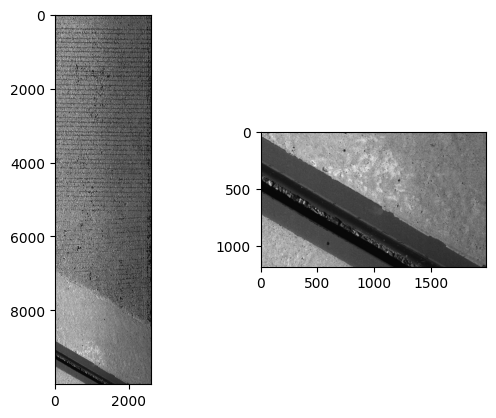

In [68]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TEXT_PROMPT = "Steel Expansion Joints"
BOX_TRESHOLD = 0.25
TEXT_TRESHOLD = 0.2

IMAGE_PATH = IMAGE_PATHS[8]
image_source, image = load_image(IMAGE_PATH)

boxes, logits, phrases = predict(
    model = groundingdino_model,
    image = image,
    caption = TEXT_PROMPT,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD,
    device = DEVICE
)

if logits.nelement() == 0:
    print("Expansion Joint is not detected...!!")
else:
    print("Expansion Joint is Detected..!")

index = logits.argmax()
box = boxes[index]

# box : normalized box xywh -> unnormalized xyxy
H, W, _ = image_source.shape
box_xyxy = box_ops.box_cxcywh_to_xyxy(box) * torch.Tensor([W, H, W, H])

# crop image
cropped_image = crop_image(IMAGE_PATH, box_xyxy)
plt.subplot(121); plt.imshow(image_source)
plt.subplot(122); plt.imshow(cropped_image, cmap='gray')

# annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
# annotated_frame = annotated_frame[...,::-1] # BGR to RGB

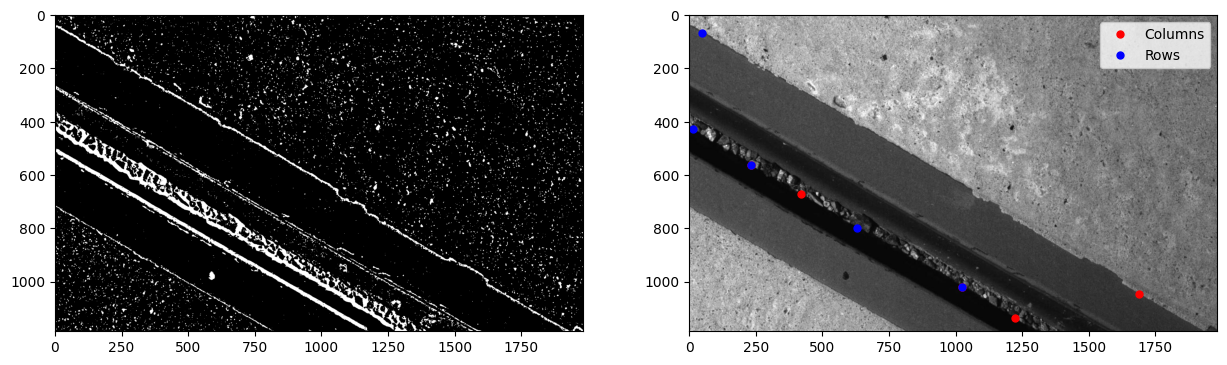

In [69]:
from skimage import measure, morphology, color
from skimage.morphology import extrema
from skimage.measure import label
from skimage.filters import threshold_multiotsu, threshold_sauvola
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy

# Ensure the image is in RGB format
cropped_image = cropped_image.convert('RGB') if cropped_image.mode != 'RGB' else cropped_image

# Convert the PIL Image to a NumPy array and ensure it's float32 (if necessary)
np_cropped_image = np.array(cropped_image).astype(np.uint8)

image = copy.deepcopy(np_cropped_image)
gimage = color.rgb2gray(image)

window_size = 29
sauvola_thresh = threshold_sauvola(gimage, window_size=window_size)
binary_mask = gimage < sauvola_thresh
_mask = morphology.remove_small_objects(binary_mask, 1000)

# Sampled points plotting
column_coordinates = column_based_sampling(gimage, _mask, num_samples=5, num_columns=5)
row_coordinates = row_based_sampling(gimage, _mask, num_samples=5, num_rows=5)

plt.figure(figsize=(15, 8))
plt.subplot(121); plt.imshow(binary_mask, cmap='gray')
plt.subplot(122)
plt.imshow(gimage, cmap='gray')
plt.plot(column_coordinates[:, 1], column_coordinates[:, 0], 'r.', markersize=10, label='Columns')
plt.plot(row_coordinates[:, 1], row_coordinates[:, 0], 'b.', markersize=10, label='Rows')
plt.legend()
plt.show()

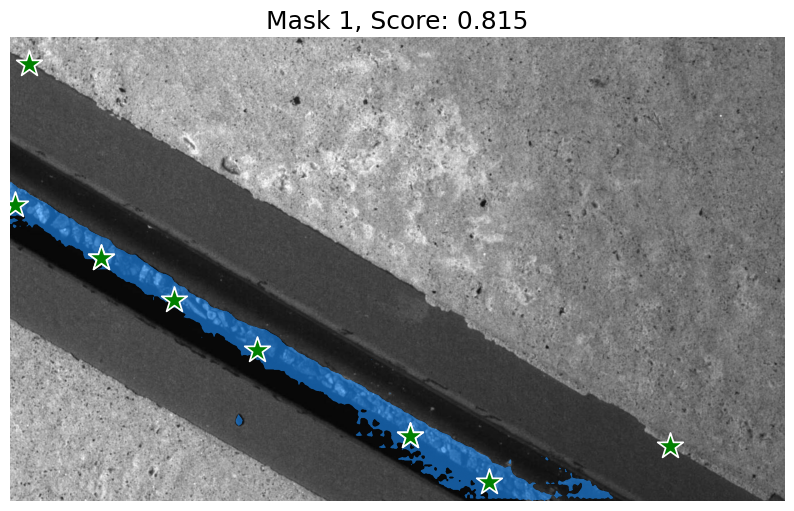

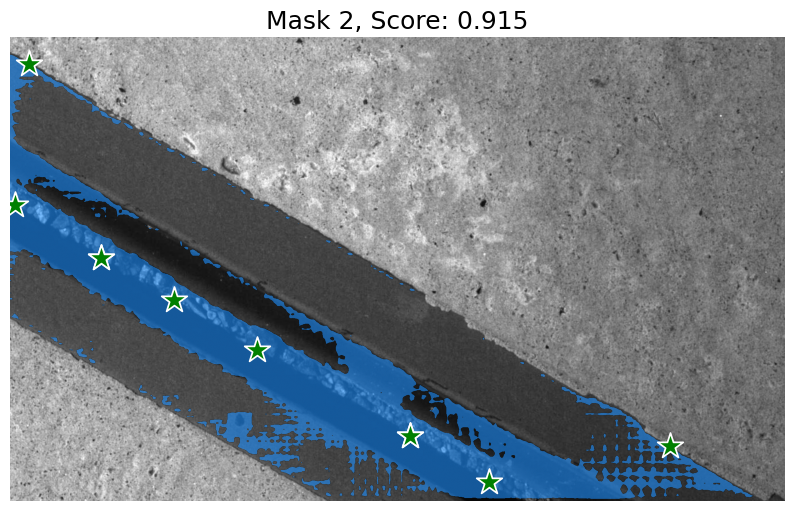

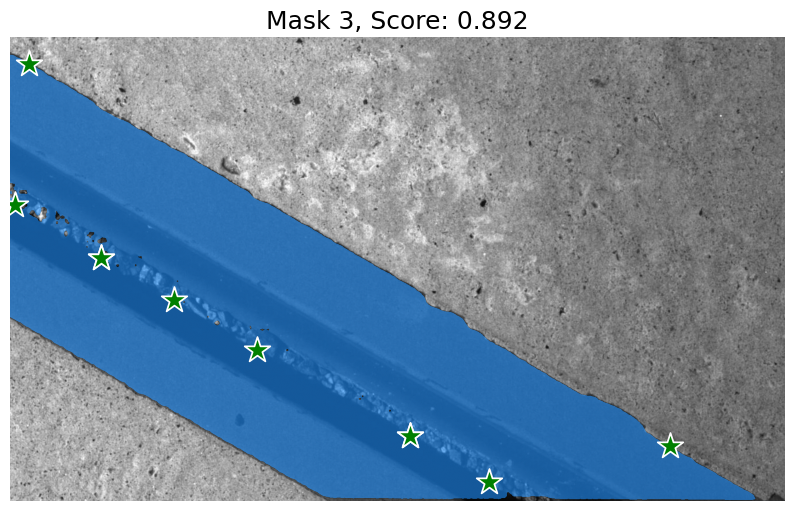

In [71]:
# Merge the arrays using np.concatenate
merged_coordinates = np.concatenate((column_coordinates, row_coordinates), axis=0)

# To swap x and y, simply reverse the order of columns
merged_coordinates_swapped = merged_coordinates[:, [1, 0]]

#input_label = np.array([1])
input_label = np.ones((len(merged_coordinates_swapped))).astype(np.int64)

sam_predictor.set_image(image)

masks, scores, logits = sam_predictor.predict(
	point_coords=merged_coordinates_swapped,
	point_labels=input_label,
	multimask_output=True,
)

for i, (mask, score) in enumerate(zip(masks, scores)):
	plt.figure(figsize=(10,10))
	plt.imshow(image)
	measurement_show_mask(mask, plt.gca())
	measurement_show_points(merged_coordinates_swapped, input_label, plt.gca())
	plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
	plt.axis('off')
	plt.show()

Expansion Joint is Detected..!


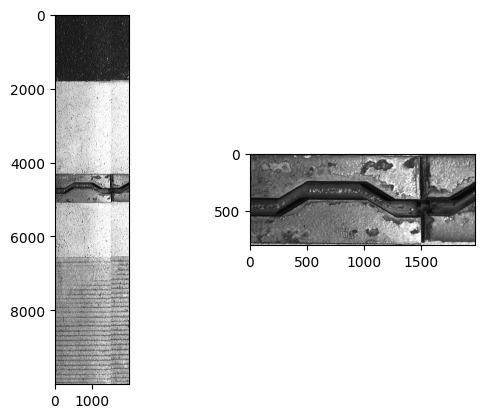

In [112]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TEXT_PROMPT = "SteelJoints"
BOX_TRESHOLD = 0.25
TEXT_TRESHOLD = 0.2

IMAGE_PATH = IMAGE_PATHS[22]
image_source, image = load_image(IMAGE_PATH)

boxes, logits, phrases = predict(
    model = groundingdino_model,
    image = image,
    caption = TEXT_PROMPT,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD,
    device = DEVICE
)

if logits.nelement() == 0:
    print("Expansion Joint is not detected...!!")
else:
    print("Expansion Joint is Detected..!")

index = logits.argmax()
box = boxes[index]

# box : normalized box xywh -> unnormalized xyxy
H, W, _ = image_source.shape
box_xyxy = box_ops.box_cxcywh_to_xyxy(box) * torch.Tensor([W, H, W, H])

# crop image
cropped_image = crop_image(IMAGE_PATH, box_xyxy)
plt.subplot(121); plt.imshow(image_source)
plt.subplot(122); plt.imshow(cropped_image, cmap='gray')

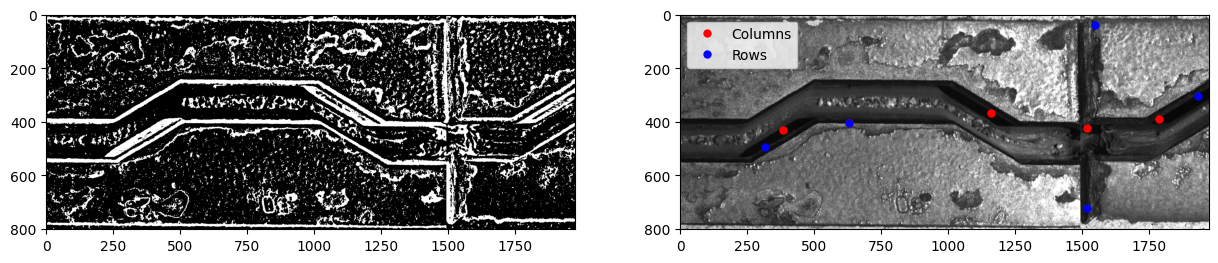

In [113]:
# Ensure the image is in RGB format
cropped_image = cropped_image.convert('RGB') if cropped_image.mode != 'RGB' else cropped_image

# Convert the PIL Image to a NumPy array and ensure it's float32 (if necessary)
np_cropped_image = np.array(cropped_image).astype(np.uint8)

image = copy.deepcopy(np_cropped_image)
gimage = color.rgb2gray(image)

# Compute the Sauvola threshold
window_size = 33
sauvola_thresh = threshold_sauvola(gimage, window_size=window_size)

# Apply the threshold to generate a binary mask
binary_mask = gimage < sauvola_thresh

# Use remove_small_objects to clean up the mask
_mask = morphology.remove_small_objects(binary_mask, 1000)

# Sampled points plotting
column_coordinates = column_based_sampling(gimage, _mask, num_samples=5, num_columns=5)
row_coordinates = row_based_sampling(gimage, _mask, num_samples=5, num_rows=5)

plt.figure(figsize=(15, 8))
plt.subplot(121); plt.imshow(binary_mask, cmap='gray')
plt.subplot(122)
plt.imshow(gimage, cmap='gray')
plt.plot(column_coordinates[:, 1], column_coordinates[:, 0], 'r.', markersize=10, label='Columns')
plt.plot(row_coordinates[:, 1], row_coordinates[:, 0], 'b.', markersize=10, label='Rows')
plt.legend()
plt.show()

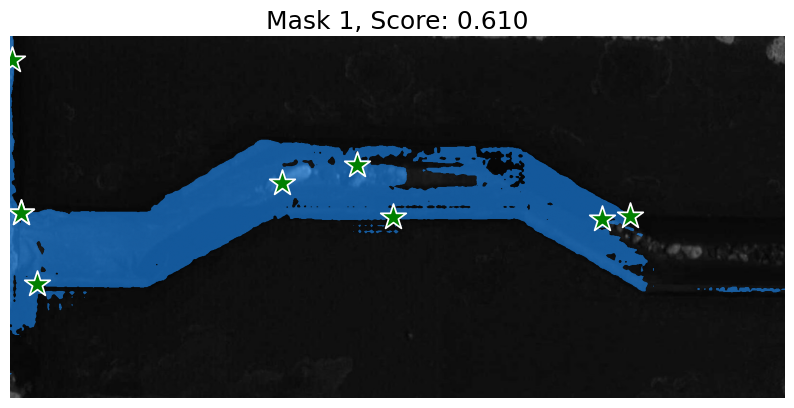

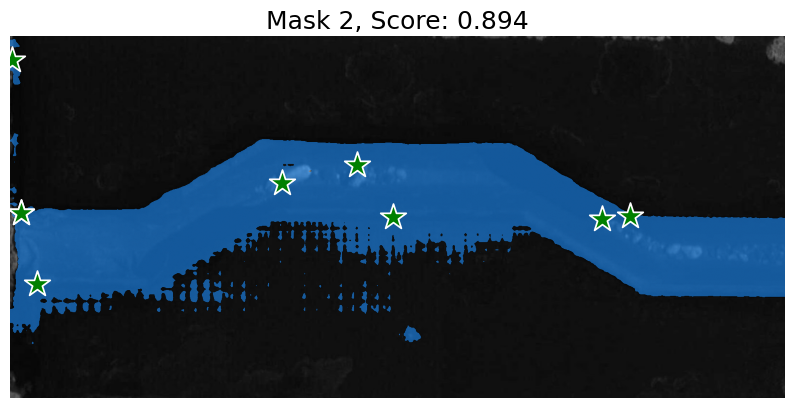

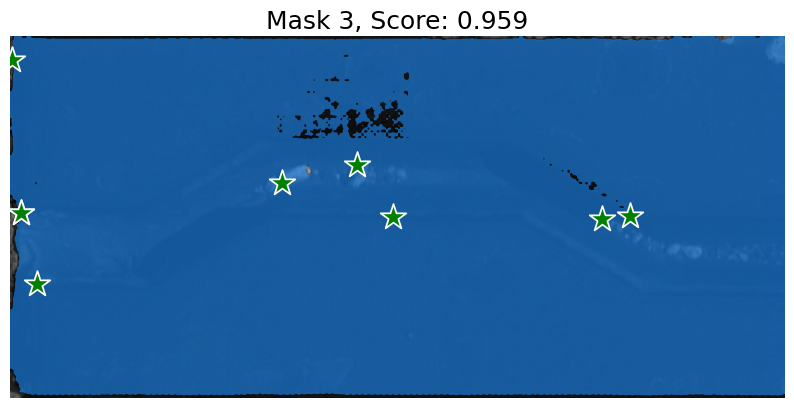

In [102]:
# Merge the arrays using np.concatenate
merged_coordinates = np.concatenate((column_coordinates, row_coordinates), axis=0)

# To swap x and y, simply reverse the order of columns
merged_coordinates_swapped = merged_coordinates[:, [1, 0]]

#input_label = np.array([1])
input_label = np.ones((len(merged_coordinates_swapped))).astype(np.int64)

sam_predictor.set_image(image)

masks, scores, logits = sam_predictor.predict(
	point_coords=merged_coordinates_swapped,
	point_labels=input_label,
	multimask_output=True,
)

for i, (mask, score) in enumerate(zip(masks, scores)):
	plt.figure(figsize=(10,10))
	plt.imshow(image)
	measurement_show_mask(mask, plt.gca())
	measurement_show_points(merged_coordinates_swapped, input_label, plt.gca())
	plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
	plt.axis('off')
	plt.show()